Slide 1
<!--- ![](../report/presentations/20231205/1.png) -->

# Pipeline

Slides 2-4
<!--- ![](../report/presentations/20231205/2.png)
![](../report/presentations/20231205/3.png)
![](../report/presentations/20231205/4.png)--->

## Setup

### Imports

In [1]:
# External imports
import os
import sys
import openai

# Get the current working directory (assuming the notebook is in the notebooks folder)
current_dir = os.getcwd()

# Add the parent directory (project root) to the Python path
parent_dir = os.path.dirname(current_dir)
sys.path.append(parent_dir)

# Relative imports
from src.utils import load_spacy, load_sbert, generate_paths, generate_color_mapping
from src.preprocess import Preprocessor
from src.modelling import get_constraints_from_data
from src.evaluation import Evaluator

### Files

In [2]:
# Define use cases with their folder names and their file identifiers (without prefix, e.g. cdm_01 for both input_cdm_01.txt and output_cdm_01.txt); if folder name and file identifier are the same, a string instead of a tuple can be used
cases = {
    "AKTG": "aktg",
    "CDM1: A/R Mangroves": ("cdm", "cdm_01"),
    "CDM2: A/R Non-wetlands": ("cdm", "cdm_02"),
    "CDM3: Cable Cars": ("cdm", "cdm_03"),
    "CDM4: Energy Efficiency": ("cdm", "cdm_04"),
    "CDM5: Electriciy Generation": ("cdm", "cdm_05"),
    "COFFEE": "coffee",
    "PATG": "patg",
}

# Generate file_paths for input and output
file_paths_input = generate_paths(cases, 'input')
file_paths_output = generate_paths(cases, 'output')

### Parameter

#### General

In [3]:
# spaCy model
# https://spacy.io/models/en
spacy_model = 'en_core_web_lg'          # best performance
# spacy_model = 'en_core_web_sm'        # one of the fastest with good performance
nlp = load_spacy(spacy_model)

# S-BERT model
# https://www.sbert.net/docs/pretrained_models.html
sbert_model = 'all-mpnet-base-v2'       # best performance
# sbert_model = 'all-MiniLM-L6-v2'      # one of the fastest with good performance
model = load_sbert(sbert_model)

# OpenAI API key
# https://help.openai.com/en/articles/5112595-best-practices-for-api-key-safety
openai.api_key = os.environ["OPENAI_API_KEY"]
# Alternative: (WARNING: NEVER COMMIT THE KEY TO THE REPOSITORY)
# openai.api_key = 'yourkey'

# Flag to determine if output should be generated
verbose = True

The model en_core_web_lg is already installed!


#### Builder

In [30]:
builder_params = {
    # https://platform.openai.com/docs/models/
    # https://openai.com/pricing
    "openai_params": {
        'model': 'gpt-3.5-turbo-0125',
        'input_price':  0.0005, # $ / 1K token
        'output_price': 0.0015, # $ / 1K token
    },
    # "openai_params":{
    #     'model': 'gpt-4-1106-preview',
    #     'input_price':  0.01, # $ / 1K token
    #     'output_price': 0.03, # $ / 1K token
    # },
    "build_mode": "rules", # "openai"
    # estimation_mode is only considered if build_mode == 'openai'. WARNING: Setting this to false will result in costs, do at least one run with estimation_mode == True
    "estimation_mode": False,
    # Nr of tokens to consider for rule-based building
    "keep_tokens": 4, 
    # Types of POS tags to consider for rule-based building; if empty, no filtering for POS tag
    "filter_pos": ['ADJ', 'NOUN', 'VERB'],
    # General prompt building blocks
    "general_prompts": {
        "system_prompt": "You are a linguist. Your task is to fit the output in a compact way into the placeholder X while preserving the formatting and overall template that I provide. Keep the output very brief, only using nouns, verbs and adjectives. Use _ to connect the parts of the output on each side of the equation.",
        "prompt_2_a": "This is the template: X",
        "prompt_2_b": ". Extract X from the following text:"
    },
    # Prompt building blocks for BOOL constraint
    "BOOL": {
        "prompt_1": "This is the template: X == True. Extract X from the following text: land subject to project activity be degrade mangrove habitat",
        "response_1": "degraded_mangrove_habitat == True"
    },
    # Prompt building blocks for regular EQ constraint components
    "EQ": {
        "prompt_1": "This is the template: X == False. Extract X from the following text: not apply to large - scale a / r CDM project activity",
        "response_1": "large_scale == False"
    },
    # Prompt building blocks for regular INEQ constraint components
    "INEQ": {
        "prompt_1": "This is the template: X <= 15. Extract X from the following text: to qualify as a small - scale project , total output of modify or retrofit unit shall not exceed limit of 15 MW",
        "response_1": "total_output_modify_or_retrofit <= 15"
    }
}

#### Evaluator

In [31]:
eval_params = {
    # Weights to apply to the scores of STEP 1, STEP 2 and the CONSTRAINT
    "weights": [0.0, 0.0, 1.0], 
    # All similarity scores lower than cutoff are set to 0
    "cutoff": 0.5,
    "plot_curves": True,
    "plot_figsize": (10, 6),
    "plot_alpha": 0.8,
    "save_plot": True,
    "folder": "evaluation",
    "run_id": "openai_gpt3_5",
    "cmap": generate_color_mapping(cases)
}

#### Preprocessor

In [6]:
# Needed because spaCy struggles with linebreak characters, but the information is important for the enumeration (see also https://github.com/explosion/spaCy/issues/7735)
linebreak = " NEWLINE "

pp_params = {
    # Define custom stop words
    'add_stop_words':[],
    'non_stop_words': list(
        """
        a above all amount and as at

        be before below between beyond both by

        can

        each either else even except

        for

        i if 

        last least less

        may more most must 

        name next no none not nothing

        of on only otherwise over or out

        per

        same several should

        than then to

        under up

        what when with
        """.split()
    ),
    # Define character sequences to replace (order is important)
    'replace': {
        ",": " , ", # Remove this line if any numbers with thousands (e.g. 1,000.00)
        "\n\n": "\n", 
        "\n \n": "\n",
        "\n \n\n": "\n",
        "\n\n \n": "\n",
        "\n": linebreak
    },
    # Define character sequences to remove (and replace with a whitespace)
    'remove': ["\t", "   ", "  "],
    # Patterns for different enumeration items types for regex matching (to split into chunks)
    'enum_patterns_regex': {
        'number_in_parentheses': r"\(\d+\)",
        'number_with_dot': r"\d+\.",
        'alphabetical_in_parentheses': r"\([a-z]\)",
        'roman_numeral_in_parentheses': r"\([ivxlcdm]+\)",
    },
    # Patterns for different enumeration items types for spaCy matching (to label enumeration tokens)
    # Every pattern has to have a preceeding linebreak; additionally, the order of the pattern has to be followed (e.g., "v" as alphabetical_in_parentheses can only be a match, if the previous one was also alphabetical_in_parentheses 
    'enum_patterns_spacy': {
        'number_in_parentheses': [{"TEXT": "("}, {"IS_DIGIT": True}, {"TEXT": ")"}],
        'number_with_dot': [{"IS_DIGIT": True}, {"TEXT": "."}, {"IS_DIGIT": False}],
        'alphabetical_in_parentheses': [{"TEXT": "("}, {"TEXT": {"IN": ["a", "b", "c", "d", "e", "f", "g", "h"]}}, {"TEXT": ")"}],
        'roman_numeral_in_parentheses': [{"TEXT": "("}, {"TEXT": {"IN": ["i", "ii", "iii", "iv", "v", "vi", "vii", "viii"]}}, {"TEXT": ")"}],
    }
}

#### Searcher

In [7]:
no_digit_or_period = [{"TEXT": {"NOT_IN": ["."]}, "IS_DIGIT": False, "OP": "*"}]

# Define inequality matching parameters
inequality_params = {
    "general": {
        "below": "<",
        "less than": "<",
        "low than": "<",
        "small than": "<",
        "as high as": "<=",
        "at most": "<=",
        "up to": "<=",
        "remain at": "<=",
        "eligibility limit of": "<=",
        "above": ">",
        "beyond": ">",
        "exceed": ">",
        "great than": ">",
        "high than": ">",
        "more than": ">",
        "surpass": ">",
        "at least": ">="
    },
    "exceptions": {
    },
    "exception_patterns": {
        # COFFEE
        "reach_beyond": [{"LOWER": "reach"}] + no_digit_or_period + [{"LIKE_NUM": True}] + no_digit_or_period + [{"LOWER": "beyond"}],
        "low_allow": [{"LOWER": "low"}] + no_digit_or_period + [{"LOWER": "allow"}] + no_digit_or_period + [{"LIKE_NUM": True}],
        "between": [{"LOWER": "between"}, {"LIKE_NUM": True}] + no_digit_or_period + [{"LIKE_NUM": True}],
        "brackets": [{"TEXT": "["}, {"LIKE_NUM": True}, {"IS_DIGIT": False, "OP": "?"},{"IS_DIGIT": False, "OP": "?"},{"IS_DIGIT": False, "OP": "?"},{"LIKE_NUM": True},{"IS_DIGIT": False, "OP": "*"}, {"TEXT": "]"}],
        "parentheses": [{"TEXT": "("}, {"LIKE_NUM": True}, {"IS_DIGIT": False, "OP": "?"},{"IS_DIGIT": False, "OP": "?"},{"IS_DIGIT": False, "OP": "?"},{"LIKE_NUM": True},{"IS_DIGIT": False, "OP": "*"}, {"TEXT": ")"}]
    },
    "negation_operators": {
        "<": ">=",
        "<=": ">",
        ">": "<=",
        ">=": "<"
    },
    "negation_tokens": {"not", "no", "none"},
    "window_size": (12, 0) # Very long
}

# Define equality matching parameters
equality_params = {
    "general": {
        "must": "==",
        "shall": "==",
        "should": "=="
    },
    "exceptions": {
        # AKTG
        "be to set out": "==",
        "applicable under": "==",
        # CDM1
        "apply to": "==",
        # CDM2
        "applicable to": "==",
        # CDM3
        "eligible under": "==",
        # CDM4
        "allowable project include": "==",
        # CDM5
        "category comprise": "==",
        "include category": "==",
        "be limit to": "==",
        # PATG
        "be to be": "=="
    },
    "exception_patterns": {
        # AKTG
        "may_only": [{"LOWER": "may"}] + no_digit_or_period + [{"LOWER": "only"}],
        # CDM1
        "fall_in": [{"LOWER": "fall"}] + no_digit_or_period + [{"LOWER": "category"}],
        # CDM4
        "none_may": [{"LOWER": "none"}] + no_digit_or_period + [{"LOWER": "may"}],
    },
    "negation_operators": {
        "==": "!="
    },
    "negation_tokens": {"not", "no", "none"},
    "window_size": (3, 2)
}

# Define meta matching parameters
# Due to the complex nature of the meta constraint searching process, some meta parametesr are also implicitly set within the MetaConstraintSearcher class
meta_params = {
    "enum_exceptions": {
        # CDM2
        "be include": "OR",
        # CDM5
        "at least one of": "OR"
    },
    "if_patterns": {
        "if_then": [{"LOWER": "if"}, {"TEXT": {"NOT_IN": [":",".",";"]}, "OP": "*"},{"TEXT": {"IN": [","]}, "OP": "?"}, {"LOWER": "then"}],
        "if_comma": [{"LOWER": "if"}, {"TEXT": {"NOT_IN": [":",".",";"]}, "OP": "*"},{"TEXT": {"IN": [","]}}, {"TEXT": {"NOT_IN": ["then"]}}],
        "if_case_of_comma": [{"LOWER": "case"}, {"LOWER": "of"}, {"TEXT": {"NOT_IN": [":",".",";"]}, "OP": "*"},{"TEXT": {"IN": [","]}}, {"TEXT": {"NOT_IN": ["then"]}}],
        
    },
    "for_patterns": {
        "for_colon": [{"LOWER": "for"}, {"TEXT": {"NOT_IN": [".",";",",", "for"]}, "OP": "*"},{"TEXT": {"IN": [":"]}}],
        "for_comma": [{"LOWER": "for"}, {"TEXT": {"NOT_IN": [":",".",";","for", ",", "---"]}, "OP": "*"},{"TEXT": {"IN": [","]}}, {"TEXT": {"NOT_IN": ["if"]}}]
    },
    "connectors": {
        "and": "AND",
        "and or": "OR",
        "or": "OR",
        "except when": "OR",
    },
    # Format is pattern_name : (matching_pattern, connector); only considered if encommpassed by an enumeration item
    "connector_exception_pattern": {
        # AKTG
        "semicolon": (";","AND"),
        # CDM1
        "period": (".","AND")
    },
    "negation_tokens": {"not", "no", "none"},   # Used for if_patterns and 'BOOL'
    "window_size": (0, 5),              # Used for if_patterns and 'BOOL'
    "context_limits": [".", ";"]
}

## Preprocessing

In [8]:
# Create preprocessing object
pp = Preprocessor(nlp, pp_params, linebreak, file_paths_input, verbose=False)

# Process all files
data = pp.optimized_preprocessing()

## Modelling

### Rule-based component building

In [9]:
# Set to rule-based component building
builder_params['build_mode'] = "rules"
# Search and build constraints
constraints = get_constraints_from_data(nlp, data, equality_params, inequality_params, meta_params, builder_params, verbose)


++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ 

AKTG 

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ 


++++ CHUNK ++++ 

<

++++ CHUNK ++++ 

-- source : - > Stock Corporation Act of 6 September 1965 ( Federal Law Gazette I , p. 1089 ) , as last amend by Article 7 of Act of 22 February 2023 ( Federal Law Gazette 2023 I no

++++ CHUNK ++++ 

51 ) , https://www.gesetze-im-internet.de/englisch_aktg/englisch_aktg.html , access Jan 15 2024 - > >

++++ CHUNK ++++ 

establishment of by - law
 ( 1 ) by - law must be establish by way of be record by a notary

  id  type    match     pattern    exception    negation       symbol    level    successor      context
----  ------  --------  ---------  -----------  -------------  --------  -------  -------------  -------

### LLM-assisted component building (GPT 3.5)

In [32]:
# Set to LLM-assisted component building
builder_params['build_mode'] = "openai"
# Search and build constraints
constraints = get_constraints_from_data(nlp, data, equality_params, inequality_params, meta_params, builder_params, verbose)


++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ 

AKTG 

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ 


++++ CHUNK ++++ 

<

++++ CHUNK ++++ 

-- source : - > Stock Corporation Act of 6 September 1965 ( Federal Law Gazette I , p. 1089 ) , as last amend by Article 7 of Act of 22 February 2023 ( Federal Law Gazette 2023 I no

++++ CHUNK ++++ 

51 ) , https://www.gesetze-im-internet.de/englisch_aktg/englisch_aktg.html , access Jan 15 2024 - > >

++++ CHUNK ++++ 

establishment of by - law
 ( 1 ) by - law must be establish by way of be record by a notary

  id  type    match     pattern    exception    negation       symbol    level    successor      context
----  ------  --------  ---------  -----------  -------------  --------  -------  -------------  -------

### LLM-assisted component building (GPT 4)

In [27]:
# Set to LLM-assisted component building
builder_params['build_mode'] = "openai"
# Search and build constraints
constraints = get_constraints_from_data(nlp, data, equality_params, inequality_params, meta_params, builder_params, verbose)


++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ 

AKTG 

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ 


++++ CHUNK ++++ 

<

++++ CHUNK ++++ 

-- source : - > Stock Corporation Act of 6 September 1965 ( Federal Law Gazette I , p. 1089 ) , as last amend by Article 7 of Act of 22 February 2023 ( Federal Law Gazette 2023 I no

++++ CHUNK ++++ 

51 ) , https://www.gesetze-im-internet.de/englisch_aktg/englisch_aktg.html , access Jan 15 2024 - > >

++++ CHUNK ++++ 

establishment of by - law
 ( 1 ) by - law must be establish by way of be record by a notary

  id  type    match     pattern    exception    negation       symbol    level    successor      context
----  ------  --------  ---------  -----------  -------------  --------  -------  -------------  -------

## Evaluation

In [20]:
evaluator = Evaluator(model, constraints, eval_params, file_paths_output, verbose)

In [11]:
# (extracted, gold standard)
reference = {
    "(1) Perfect": ( 
        "(co_fires_fossil_fuel == False OR capacity_entire_unit <= 15)", 
        "co_fires_fossil_fuel == False OR capacity_entire_unit < 15"),
    "(2) Great": (
        "electricity_saving_single_project <= 60", 
        "electricity_savings_per_year <= 60"),
    "(3) Good": (
        "application == disclose_invention_manner_clear", "application_dicslose_clear_and_complete == True"),
    "(4) OK": (
        "heat_power_cogeneration_system != category", 
        "combined_heat_and_power == False"),
    "(5) Bad": (
        "application == relate_invention_group_invention", 
        "application_relate_one_invention == True OR linked == True"),
    "(6) Garbage": (
        "law == establish_way",
        "recorded_by_notary == True")
}
evaluator.compare_references(reference)

+-------------+------------------------+-------------------------+
| Reference   |   Score w/ underscores |   Score w/o underscores |
+=============+========================+=========================+
| (1) Perfect |               0.964784 |                0.984341 |
+-------------+------------------------+-------------------------+
| (2) Great   |               0.850225 |                0.742961 |
+-------------+------------------------+-------------------------+
| (3) Good    |               0.254579 |                0.242127 |
+-------------+------------------------+-------------------------+
| (4) OK      |               0.613974 |                0.49853  |
+-------------+------------------------+-------------------------+
| (5) Bad     |               0.667478 |                0.707923 |
+-------------+------------------------+-------------------------+
| (6) Garbage |               0.283884 |                0.319443 |
+-------------+------------------------+----------------------

### Rule-based component building

+-----------------------------+-------------+--------------------+----------+--------------------+
| Case                        |   Precision |   Maximum possible |   Recall |   Maximum possible |
|                             |             |          precision |          |             recall |
+=============================+=============+====================+==========+====================+
| AKTG                        |    0        |                  1 | 0        |           0.75     |
+-----------------------------+-------------+--------------------+----------+--------------------+
| CDM1: A/R Mangroves         |    1        |                  1 | 0.6      |           0.6      |
+-----------------------------+-------------+--------------------+----------+--------------------+
| CDM2: A/R Non-wetlands      |    0.5      |                  1 | 0.5      |           1        |
+-----------------------------+-------------+--------------------+----------+--------------------+
| CDM3: Ca

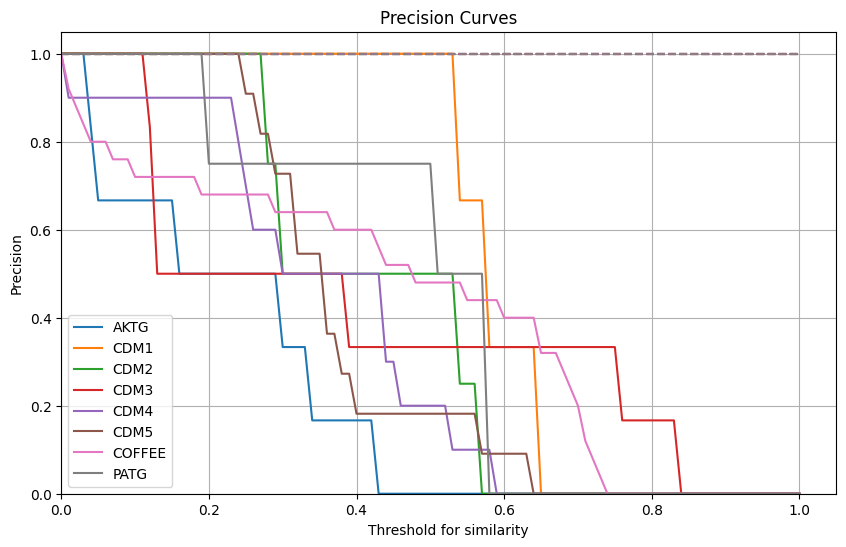

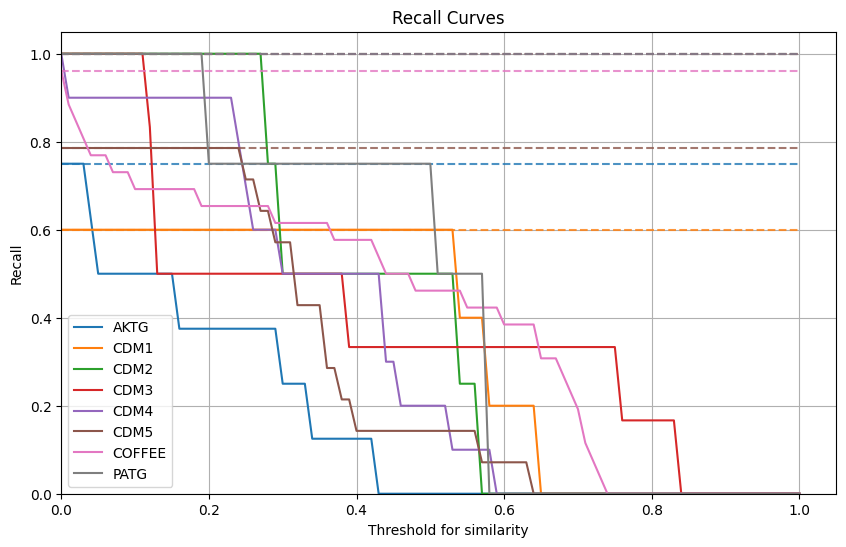

In [16]:
results = evaluator.evaluate_all()

### LLM-assisted component building (GPT 3.5)

+-----------------------------+-------------+--------------------+----------+--------------------+
| Case                        |   Precision |   Maximum possible |   Recall |   Maximum possible |
|                             |             |          precision |          |             recall |
+=============================+=============+====================+==========+====================+
| AKTG                        |    0        |                  1 | 0        |           0.75     |
+-----------------------------+-------------+--------------------+----------+--------------------+
| CDM1: A/R Mangroves         |    0.333333 |                  1 | 0.2      |           0.6      |
+-----------------------------+-------------+--------------------+----------+--------------------+
| CDM2: A/R Non-wetlands      |    0.25     |                  1 | 0.25     |           1        |
+-----------------------------+-------------+--------------------+----------+--------------------+
| CDM3: Ca

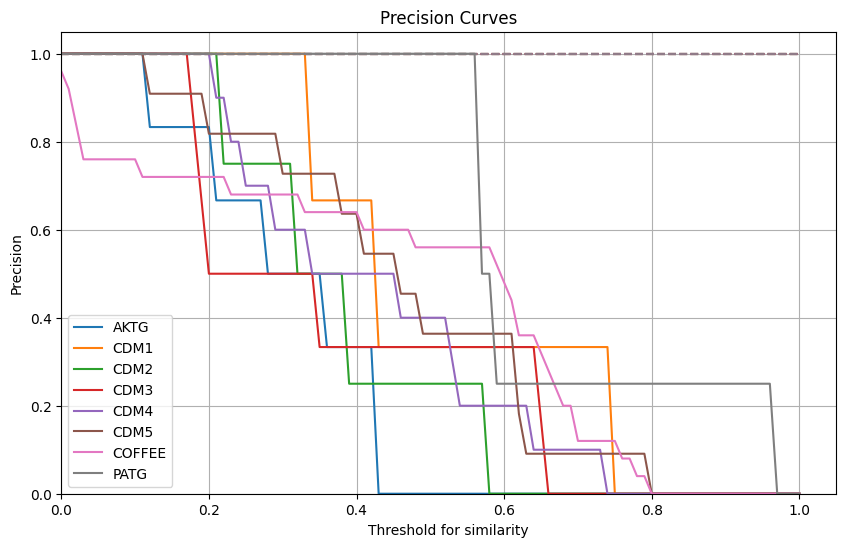

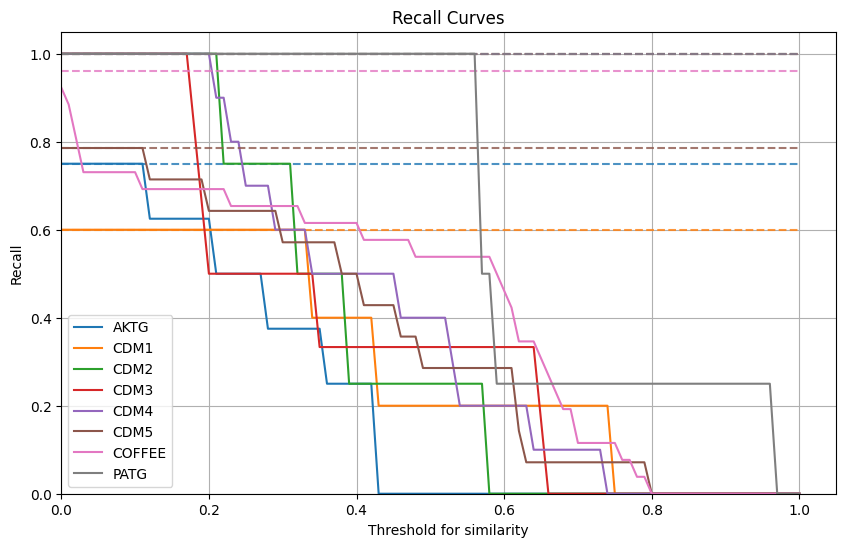

In [33]:
evaluator = Evaluator(model, constraints, eval_params, file_paths_output, verbose)
results = evaluator.evaluate_all()

### LLM-assisted component building (GPT 4)

+-----------------------------+-------------+--------------------+----------+--------------------+
| Case                        |   Precision |   Maximum possible |   Recall |   Maximum possible |
|                             |             |          precision |          |             recall |
+=============================+=============+====================+==========+====================+
| AKTG                        |    0.166667 |                  1 | 0.125    |           0.75     |
+-----------------------------+-------------+--------------------+----------+--------------------+
| CDM1: A/R Mangroves         |    0.333333 |                  1 | 0.2      |           0.6      |
+-----------------------------+-------------+--------------------+----------+--------------------+
| CDM2: A/R Non-wetlands      |    1        |                  1 | 1        |           1        |
+-----------------------------+-------------+--------------------+----------+--------------------+
| CDM3: Ca

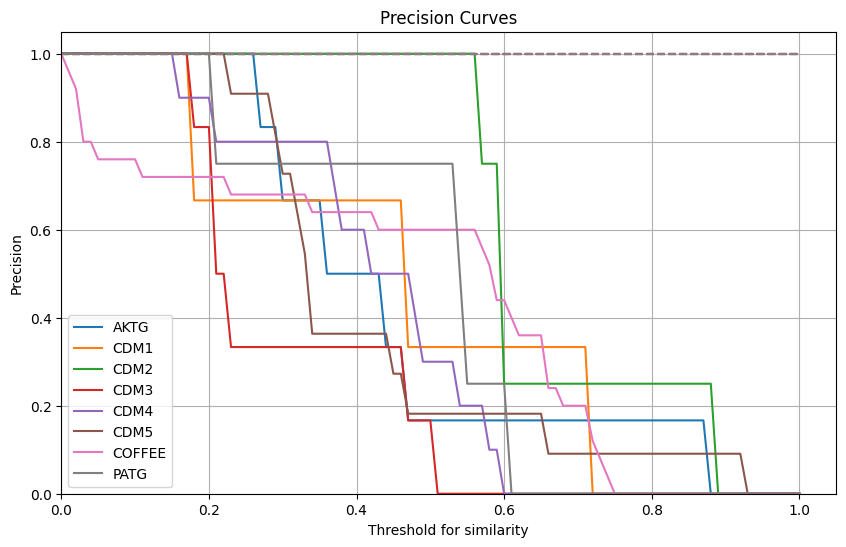

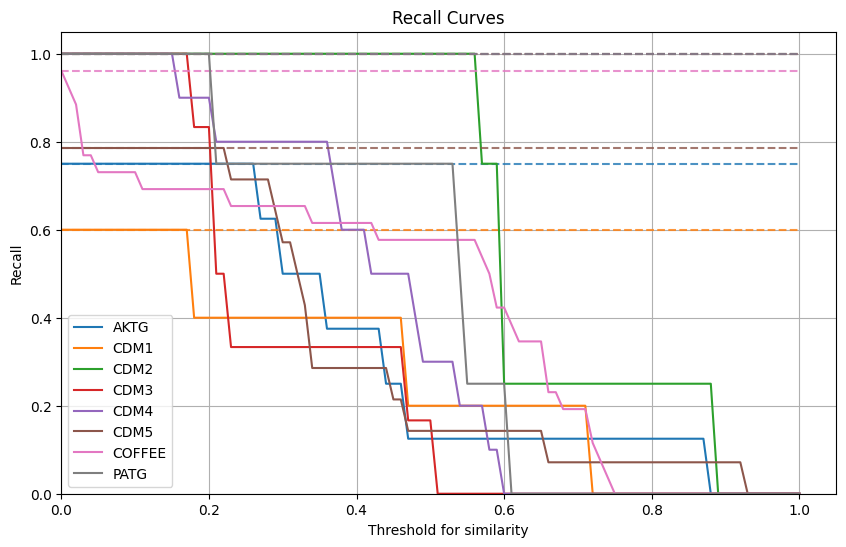

In [29]:
evaluator = Evaluator(model, constraints, eval_params, file_paths_output, verbose)
results = evaluator.evaluate_all()

#### Rule-based w/o equality or inequality exceptions

+-----------------------------+-------------+--------------------+----------+--------------------+
| Case                        |   Precision |   Maximum possible |   Recall |   Maximum possible |
|                             |             |          precision |          |             recall |
+=============================+=============+====================+==========+====================+
| AKTG                        |    0        |                  1 | 0        |           0.5      |
+-----------------------------+-------------+--------------------+----------+--------------------+
| CDM1: A/R Mangroves         |    1        |                  1 | 0.4      |           0.4      |
+-----------------------------+-------------+--------------------+----------+--------------------+
| CDM2: A/R Non-wetlands      |    0.5      |                  1 | 0.25     |           0.5      |
+-----------------------------+-------------+--------------------+----------+--------------------+
| CDM3: Ca

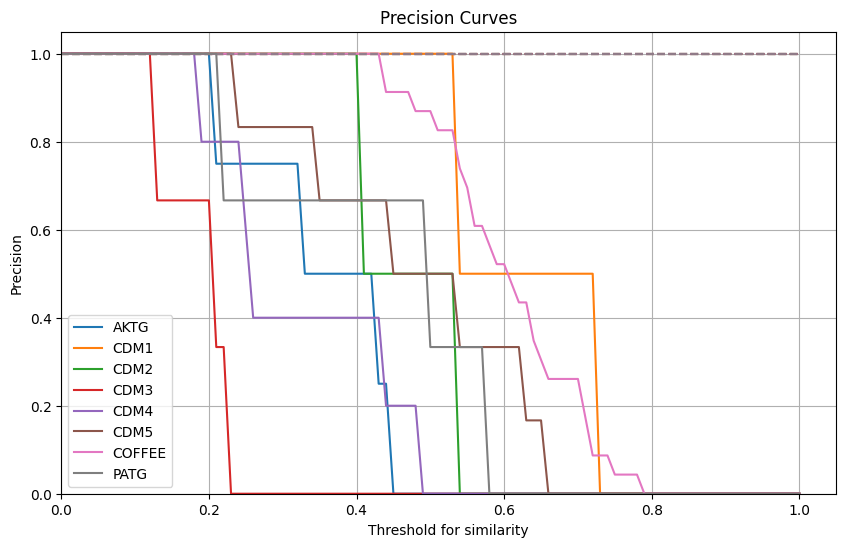

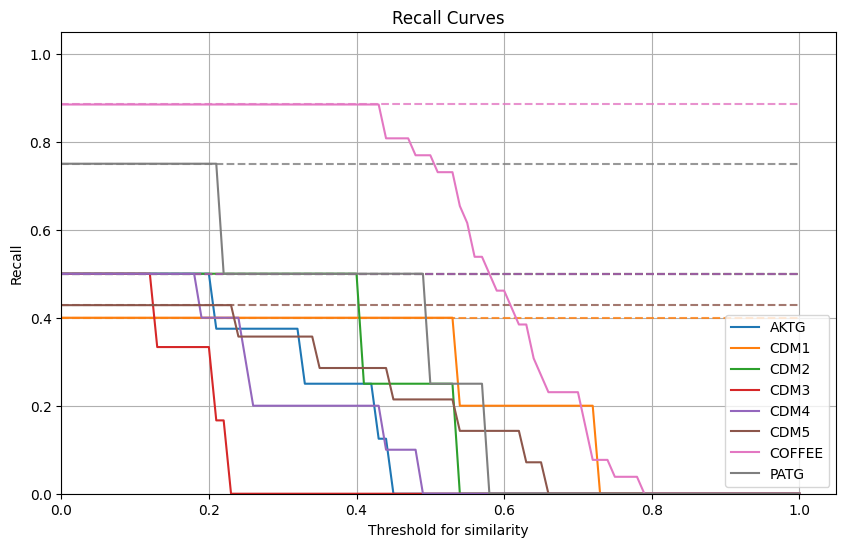

In [18]:
evaluator = Evaluator(model, constraints, eval_params, file_paths_output, verbose)
results = evaluator.evaluate_all()

#### Rule-based w/o equality or inequality constraints

No constraints extracted.
No constraints extracted.
+-----------------------------+-------------+--------------------+-----------+--------------------+
| Case                        |   Precision |   Maximum possible |    Recall |   Maximum possible |
|                             |             |          precision |           |             recall |
+=============================+=============+====================+===========+====================+
| AKTG                        |         0.5 |                  1 | 0.125     |           0.25     |
+-----------------------------+-------------+--------------------+-----------+--------------------+
| CDM1: A/R Mangroves         |         0   |                  1 | 0         |           0.2      |
+-----------------------------+-------------+--------------------+-----------+--------------------+
| CDM2: A/R Non-wetlands      |         0   |                  1 | 0         |           0.25     |
+-----------------------------+-------------+---

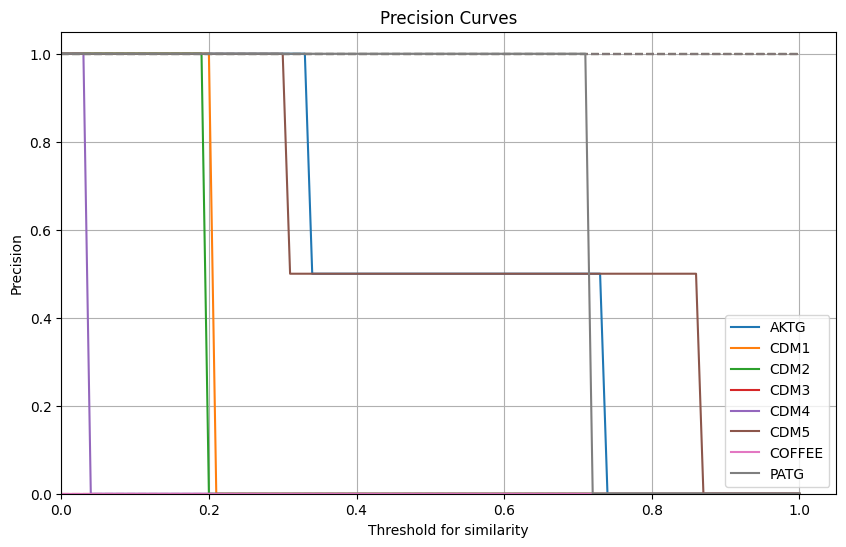

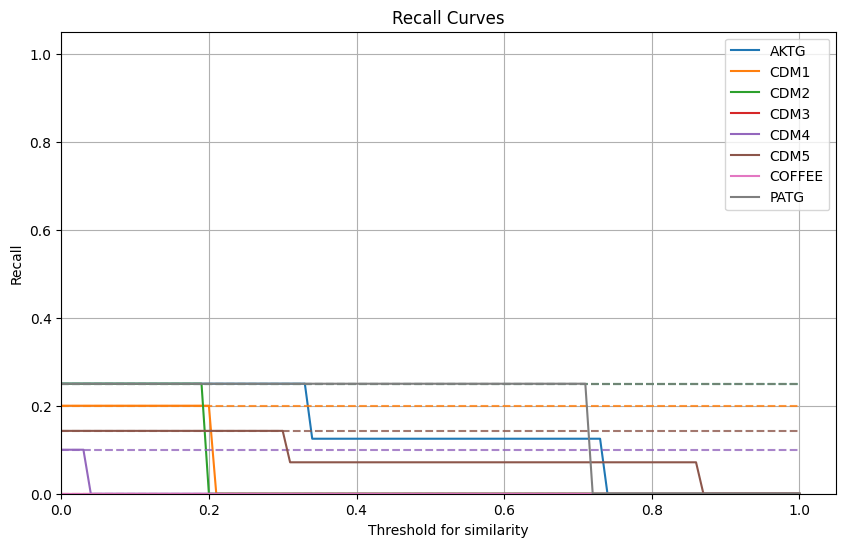

In [14]:
evaluator = Evaluator(model, constraints, eval_params, file_paths_output, verbose)
results = evaluator.evaluate_all()

Final Slides
<!-- 
![](../report/presentations/20231205/5.png)
![](../report/presentations/20231205/6.png) 
![](../report/presentations/20231205/7.png)-->